In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdate
import matplotlib.ticker as mtick
import yaml
from math import sqrt
import os
import collections
from datetime import datetime, timedelta
import time

In [2]:
def read_yaml_file(file_name):
    file_handle = open(file_name, 'r')
    data = yaml.load(file_handle)
    file_handle.close()
    return data

def load_data():
    map_file = "../../config/map.yaml"
    positions_file = "../../config/ropod_positions.yaml"
    map_dimensions = read_yaml_file(map_file)
    ropod_positions = read_yaml_file(positions_file)
    return map_dimensions, ropod_positions

def load_files(path_folder):
    files = list()
    for f in os.listdir(path_folder):
        if f.endswith('.yaml'):
            files.append(f)
    return files

def plot_ropod_positions(ropod_positions, xlim, ylim, scalability=False):
    fig = plt.figure()
    x_s = list()
    y_s = list()
    for ropod_id, position_name in ropod_positions.items():
        position = position_name['position'].split('_')
        x = float(position[3])
        y = float(position[5])
        x_s.append(x)
        y_s.append(y)

    plt.scatter(x_s, y_s)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.gca().set_aspect('equal')
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    if scalability: 
        plt.title("Robots initial positions for scalability tests")
    else:
        plt.title("Robots initial positions")
    plt.grid()
    if scalability: 
        fig.savefig('robots_ini_scalability' + ".png")
    else:
        fig.savefig('robots_ini' + ".png")
    plt.show()
     
def draw_circles(centroid, radius, ax):
    circle = plt.Circle(centroid, radius, color='g', fill=False)
    ax.add_artist(circle)
    
def get_start_time(path_dataset_folder, dataset_file):
    dataset = read_yaml_file(path_dataset_folder + '/' + dataset_file)
    start_time = dataset['start_time']
    return start_time
    
def plot_dataset_uniform_spatial(path_dataset_folder, xlim, ylim):
    dataset_files = load_files(path_dataset_folder)
    # Order dataset_files alphabetically
    dataset_files.sort()
    for dataset_file in dataset_files:
        print(dataset_file)
        points = read_yaml_file(path_dataset_folder + '/' + dataset_file)
        fig = plt.figure()
        delivery_points = list()
        pickup_points = list()
    
        for point_type in points:
            ax = fig.add_subplot(111)
            if point_type == "pickup":
                pickup_points = points[point_type]
            elif point_type == "delivery":
                delivery_points = points[point_type]
        
        print ("Pickup_points", pickup_points)
        print ("Delivery_points", delivery_points)
    
        for i in range(0, len(pickup_points)):
            plt.plot([pickup_points[i][0],delivery_points[i][0]], [pickup_points[i][1],delivery_points[i][1]], 'r-')
            plt.plot(delivery_points[i][0],delivery_points[i][1],'r', marker='*')


        dataset_name = dataset_file.split(".")[0]
        dataset_name = dataset_name.replace('Points-','')
        
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.gca().set_aspect('equal')
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.title("Spatial Distribution: Dataset " + dataset_name)
        plt.grid()
        fig.savefig(dataset_name + "-spatial.png")
        #plt.show()
        plt.draw()
        
        
def plot_dataset_clustered_spatial(path_dataset_folder, xlim, ylim):
    dataset_files = load_files(path_dataset_folder)
    # Order dataset_files alphabetically
    dataset_files.sort()
    for dataset_file in dataset_files:
        print(dataset_file)
        points = read_yaml_file(path_dataset_folder + '/' + dataset_file)
        fig = plt.figure()
                
        for cluster, values in points.items():
            ax = fig.add_subplot(111)
            points_t = values['points']
            print ("Cluster id:", cluster)
            print ("Centroid:", values['centroid'])
            print ("Tasks:\n", values['tasks'])
            print ('')

            ax.plot(values['centroid'][0], values['centroid'][1], 'bo')
            draw_circles(values['centroid'], values['radius'], ax)
       
            # for point in values['points']:
            for i in range(0, len(points_t)-1, 2):
                # print "Pickup: ", points[i], points[i][0], points[i][1]
                # print "Delivery: ", points[i+1], points[i+1][0], points[i+1][1]

                # Connect pickup_point to delivery_point with a line
                ax.plot([points_t[i][0],points_t[i+1][0]], [points_t[i][1],points_t[i+1][1]], 'r-')

                # Mark delivery point
                ax.plot(points_t[i+1][0], points_t[i+1][1],'r', marker='*')
            
        dataset_name = dataset_file.split(".")[0]
        dataset_name = dataset_name.replace('Points-','')
        
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.gca().set_aspect('equal')

        #plt.axis('equal')
        #plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
        #plt.xlim(xlim)
        #plt.ylim(ylim)
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.title("Spatial Distribution: Dataset " + dataset_name)
        plt.grid()
        fig.savefig(dataset_name + "-spatial.png")
        #plt.show()
        plt.draw()
        
        
def plot_temporal_windows(tasks, dataset_name, start_time):
    n_tasks = len(tasks)
    print("n_tasks: ", n_tasks)
    n_task = 1
    f_t = float('Inf') # First time of all time windows
    l_t = -float('Inf') # last time of all time windows

    print(dataset_name)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    task_ids = list()

    for task, value in tasks.items():
        task_ids.append(task)
        e_s_t = value['earliest_start_time']
        l_f_t = value['latest_start_time'] + value['estimated_duration']

        if e_s_t < f_t:
            f_t = e_s_t
        if l_f_t > l_t:
            l_t = l_f_t

        # Convert form epoch to datetime object
        start_window = datetime.fromtimestamp(e_s_t)
        end_window = datetime.fromtimestamp(l_f_t)

        # convert to matplotlib date representation
        start_rectangle = mdate.date2num(start_window)
        end_rectangle = mdate.date2num(end_window)
        width_rectangle = end_rectangle - start_rectangle

        rect = Rectangle((start_rectangle, n_task), width_rectangle, 0.2, color='blue')
        ax.add_patch(rect)
        n_task += 1

    first_time = datetime.fromtimestamp(start_time)
    last_time = datetime.fromtimestamp(l_t)
    first =  mdate.date2num(first_time)
    last =  mdate.date2num(last_time)
    
    date_fmt = '%H:%M:%S'
    # Use a DateFormatter to set the data to the correct format.
    date_formatter = mdate.DateFormatter(date_fmt)
    ax.xaxis.set_major_formatter(date_formatter)

    # Sets the tick labels diagonal so they fit easier.
    fig.autofmt_xdate()
    # set the limits
    plt.xlim([first-width_rectangle, last+width_rectangle])
    plt.ylim([0, n_tasks+1])

    plt.xlabel("Time (hours:minutes:seconds)")
    plt.ylabel("Task number")
    plt.title("Temporal Distribution: Dataset " + dataset_name)

    plt.draw()
    plt.grid()
    fig.savefig(dataset_name + "-temporal.png")

    plt.show()
    

def plot_dataset_temporal(path_dataset_folder, xlim, ylim):
    dataset_files = load_files(path_dataset_folder)
    # Order dataset_files alphabetically
    dataset_files.sort()
    for dataset_file in dataset_files:
        dataset = read_yaml_file(path_dataset_folder + '/' + dataset_file)
        start_time = dataset['start_time']
        print("Start time: ", datetime.fromtimestamp(start_time))
        
        tasks = dataset['tasks']
        dataset_name = dataset_file.split(".")[0]

        plot_temporal_windows(tasks, dataset_name, start_time)
        
            
def plot_batch_temporal(path_dataset_folder, xlim, ylim):
    print(path_dataset_folder)
    path_batched_dataset_folder = path_dataset_folder + '/batches'
    print(path_batched_dataset_folder)
    batched_dataset_files = load_files(path_batched_dataset_folder)
    batched_dataset_files.sort()
    
    
    for batched_dataset_file in batched_dataset_files:
        batched_dataset = read_yaml_file(path_batched_dataset_folder + '/' + batched_dataset_file)
        batch_name = batched_dataset_file.split(".")[0]
        print("Batch name: ", batch_name)
        dataset_file = batch_name.split("_")[0] + '.yaml'
        
        print("Dataset_file", dataset_file)
        start_time = get_start_time(path_dataset_folder, dataset_file) 
        print("Start time: ", start_time)
        
        n_tasks = 0
        for batch_id, tasks in  batched_dataset['batches'].items():
            for task in tasks:
                n_tasks += 1
                
        print("Batch name: ", batch_name)
        print("n_tasks: ", n_tasks)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        f_t = float('Inf') # First time of all time windows
        l_t = -float('Inf') # last time of all time windows
        task_ids = list()
        n_task = 1

        for batch_id, tasks in batched_dataset['batches'].items():
            for task, value in tasks.items():
                task_ids.append(task)
                e_s_t = value['earliest_start_time']
                l_f_t = value['latest_start_time'] + value['estimated_duration']

                if e_s_t < f_t:
                    f_t = e_s_t
                if l_f_t > l_t:
                    l_t = l_f_t
                    
                # Convert form epoch to datetime object
                start_window = datetime.fromtimestamp(e_s_t)
                end_window = datetime.fromtimestamp(l_f_t)

                # convert to matplotlib date representation
                start_rectangle = mdate.date2num(start_window)
                end_rectangle = mdate.date2num(end_window)
                width_rectangle = end_rectangle - start_rectangle

                rect = Rectangle((start_rectangle, n_task), width_rectangle, 0.2, color='blue')
                ax.add_patch(rect)
                n_task += 1

        first_time = datetime.fromtimestamp(start_time)
        last_time = datetime.fromtimestamp(l_t)
        first =  mdate.date2num(first_time)
        last =  mdate.date2num(last_time)
        
        date_fmt = '%H:%M:%S'
        # Use a DateFormatter to set the data to the correct format.
        date_formatter = mdate.DateFormatter(date_fmt)
        ax.xaxis.set_major_formatter(date_formatter)

        # Sets the tick labels diagonal so they fit easier.
        fig.autofmt_xdate()
        # set the limits
        plt.xlim([first-width_rectangle, last+width_rectangle])
        plt.ylim([0, n_tasks+1])

        plt.xlabel("Time (hours:minutes:seconds)")
        plt.ylabel("Task number")
        plt.title("Temporal Distribution: Dataset " + batch_name)
    
        plt.draw()
        plt.grid()
        fig.savefig(batch_name + "-temporal.png")
       
        plt.show()


def plot_dataset_uniform_spatial_clustered_temporal(path_dataset_folder, xlim, ylim):
    dataset_files = load_files(path_dataset_folder)
    # Order dataset_files alphabetically
    dataset_files.sort()

    for dataset_file in dataset_files:
        print(dataset_file)
        points = read_yaml_file(path_dataset_folder + '/' + dataset_file)
        fig = plt.figure()
        delivery_points = list()
        pickup_points = list()
        
        for cluster, values in points.items():
            ax = fig.add_subplot(111)
            ax.plot(values['centroid'][0], values['centroid'][1], 'bo')
            draw_circles(values['centroid'], values['radius'], ax)
            
            for point in values['pickup']:
                pickup_points.append(point)
            for point in values['delivery']:
                delivery_points.append(point)
          
            
        print("Pickup: ", pickup_points)
        print("Delivery: ",delivery_points)
        
        for i in range(0, len(pickup_points)):
            ax.plot([pickup_points[i][0],delivery_points[i][0]], [pickup_points[i][1],delivery_points[i][1]], 'r-')
            ax.plot(delivery_points[i][0],delivery_points[i][1],'r', marker='*')


        dataset_name = dataset_file.split(".")[0]
        dataset_name = dataset_name.replace('Points-','')
        
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.gca().set_aspect('equal')
        plt.xlabel("x [m]")
        plt.ylabel("y [m]")
        plt.title("Spatial Distribution: Dataset " + dataset_name)
        plt.grid()
        fig.savefig(dataset_name + "-spatial.png")
        # plt.show()
        plt.draw()


        


(0.0, 20.0)
(0.0, 20.0)


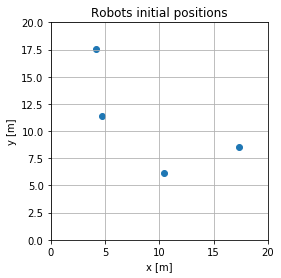

Points-SDU-TER-1.yaml
('Pickup_points', [[18.73, 16.59], [3.19, 1.57], [14.08, 5.7], [0.62, 1.41]])
('Delivery_points', [[8.01, 14.8], [5.56, 6.03], [0.84, 5.41], [2.8, 12.01]])
Points-SDU-TER-2.yaml
('Pickup_points', [[13.75, 7.67], [8.0, 14.43], [0.87, 3.84], [0.91, 7.18]])
('Delivery_points', [[8.23, 0.56], [7.85, 1.22], [19.24, 15.9], [1.72, 1.63]])
Points-SDU-TER-3.yaml
('Pickup_points', [[2.89, 8.59], [5.99, 0.74], [16.52, 2.76], [11.71, 8.16]])
('Delivery_points', [[16.46, 17.57], [15.1, 9.21], [14.1, 19.13], [8.31, 1.91]])


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Points-SDU-TER-4.yaml
('Pickup_points', [[9.5, 18.31], [11.32, 11.38], [14.86, 14.05], [16.75, 0.35]])
('Delivery_points', [[15.76, 19.42], [4.56, 12.11], [1.83, 14.12], [8.8, 12.45]])
Points-SDU-TER-5.yaml
('Pickup_points', [[8.39, 9.09], [8.28, 5.87], [6.68, 17.21], [3.15, 2.18]])
('Delivery_points', [[19.83, 4.69], [10.27, 16.85], [12.99, 1.29], [1.89, 15.82]])
('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 7, 162624))
('n_tasks: ', 4)
SDU-TER-1


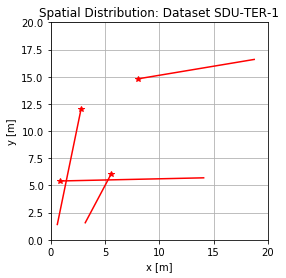

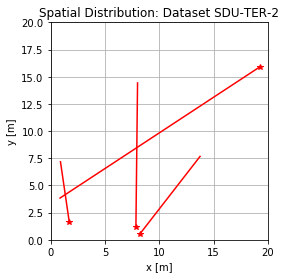

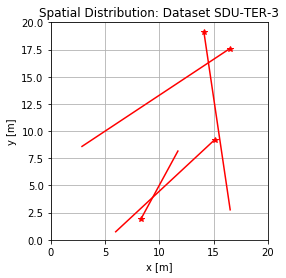

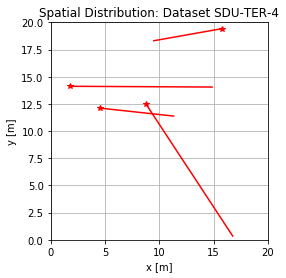

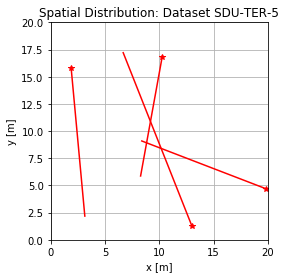

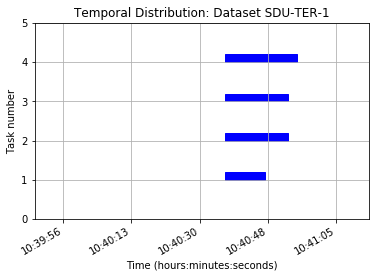

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 7, 182408))
('n_tasks: ', 4)
SDU-TER-2


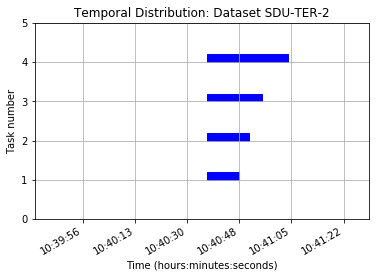

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 7, 194620))
('n_tasks: ', 4)
SDU-TER-3


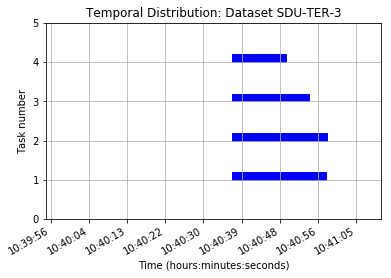

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 7, 208073))
('n_tasks: ', 4)
SDU-TER-4


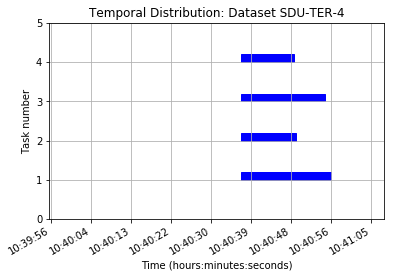

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 7, 223386))
('n_tasks: ', 4)
SDU-TER-5


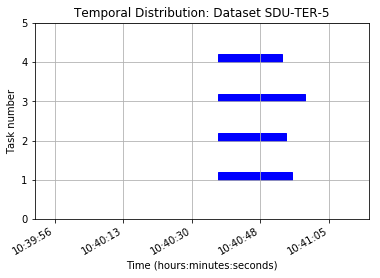

Points-SDU-TGR-1.yaml
('Pickup_points', [[7.63, 5.75], [15.8, 6.86], [0.47, 7.35], [6.52, 4.57], [8.82, 10.48], [13.21, 11.91], [16.56, 0.74], [19.95, 13.06]])
('Delivery_points', [[18.47, 12.06], [9.93, 9.08], [1.06, 0.49], [7.47, 9.63], [13.53, 0.04], [17.5, 7.49], [16.7, 7.19], [9.44, 5.66]])
Points-SDU-TGR-2.yaml
('Pickup_points', [[13.72, 16.43], [18.94, 4.03], [10.25, 8.83], [12.12, 4.79], [15.85, 2.26], [2.75, 18.96], [6.3, 6.51], [15.29, 8.59]])
('Delivery_points', [[7.92, 12.75], [5.02, 18.65], [8.82, 2.94], [11.87, 3.55], [11.32, 15.79], [13.93, 15.58], [5.23, 13.9], [17.44, 9.95]])
Points-SDU-TGR-3.yaml
('Pickup_points', [[2.3, 17.03], [16.23, 0.94], [11.09, 13.59], [7.41, 19.36], [8.07, 8.61], [19.83, 6.14], [12.04, 2.16], [11.18, 17.22]])
('Delivery_points', [[1.76, 1.2], [3.02, 4.59], [9.66, 3.34], [14.26, 17.34], [13.3, 10.42], [10.73, 8.33], [1.21, 8.33], [18.74, 3.62]])
Points-SDU-TGR-4.yaml
('Pickup_points', [[9.45, 8.29], [16.85, 3.2], [19.21, 0.47], [8.23, 10.15], [

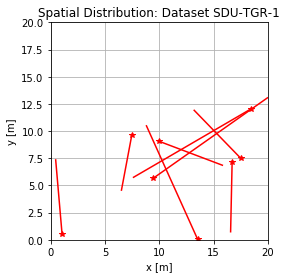

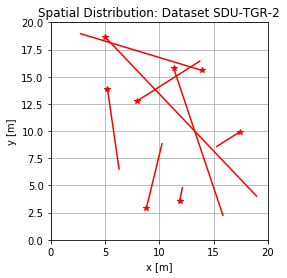

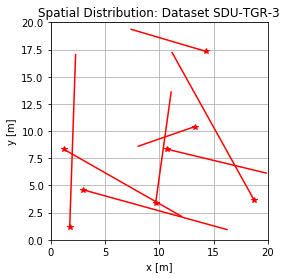

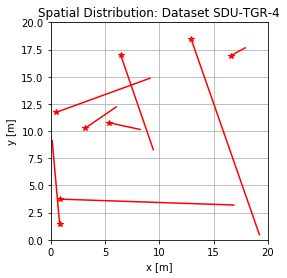

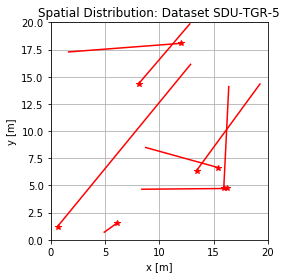

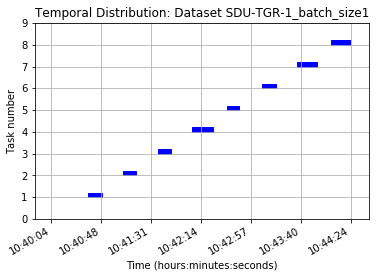

('Batch name: ', 'SDU-TGR-1_batch_size2')
('Dataset_file', 'SDU-TGR-1.yaml')
('Start time: ', 1540719607.240887)
('Batch name: ', 'SDU-TGR-1_batch_size2')
('n_tasks: ', 8)


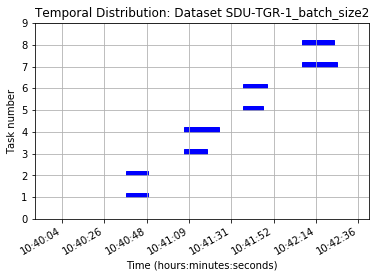

('Batch name: ', 'SDU-TGR-1_batch_size4')
('Dataset_file', 'SDU-TGR-1.yaml')
('Start time: ', 1540719607.240887)
('Batch name: ', 'SDU-TGR-1_batch_size4')
('n_tasks: ', 8)


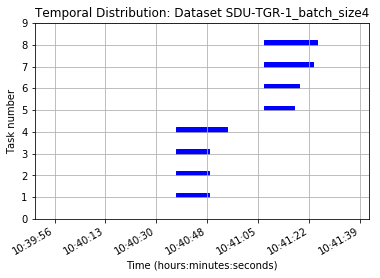

('Batch name: ', 'SDU-TGR-2_batch_size1')
('Dataset_file', 'SDU-TGR-2.yaml')
('Start time: ', 1540719607.268088)
('Batch name: ', 'SDU-TGR-2_batch_size1')
('n_tasks: ', 8)


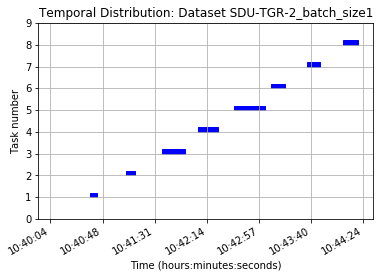

('Batch name: ', 'SDU-TGR-2_batch_size2')
('Dataset_file', 'SDU-TGR-2.yaml')
('Start time: ', 1540719607.268088)
('Batch name: ', 'SDU-TGR-2_batch_size2')
('n_tasks: ', 8)


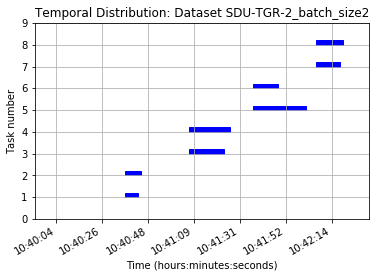

('Batch name: ', 'SDU-TGR-2_batch_size4')
('Dataset_file', 'SDU-TGR-2.yaml')
('Start time: ', 1540719607.268088)
('Batch name: ', 'SDU-TGR-2_batch_size4')
('n_tasks: ', 8)


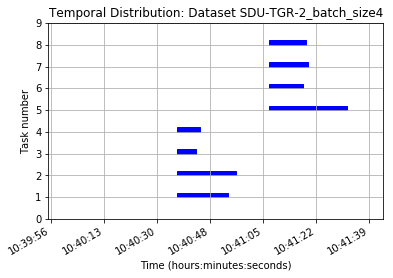

('Batch name: ', 'SDU-TGR-3_batch_size1')
('Dataset_file', 'SDU-TGR-3.yaml')
('Start time: ', 1540719607.29863)
('Batch name: ', 'SDU-TGR-3_batch_size1')
('n_tasks: ', 8)


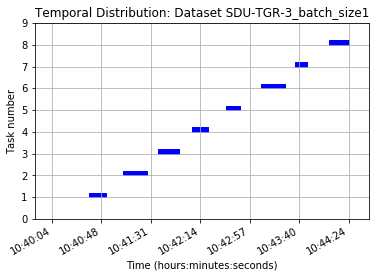

('Batch name: ', 'SDU-TGR-3_batch_size2')
('Dataset_file', 'SDU-TGR-3.yaml')
('Start time: ', 1540719607.29863)
('Batch name: ', 'SDU-TGR-3_batch_size2')
('n_tasks: ', 8)


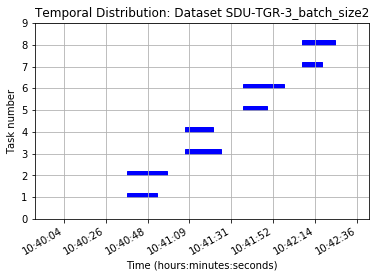

('Batch name: ', 'SDU-TGR-3_batch_size4')
('Dataset_file', 'SDU-TGR-3.yaml')
('Start time: ', 1540719607.29863)
('Batch name: ', 'SDU-TGR-3_batch_size4')
('n_tasks: ', 8)


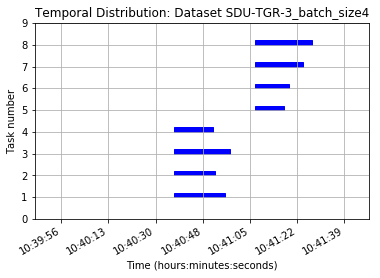

('Batch name: ', 'SDU-TGR-4_batch_size1')
('Dataset_file', 'SDU-TGR-4.yaml')
('Start time: ', 1540719607.333359)
('Batch name: ', 'SDU-TGR-4_batch_size1')
('n_tasks: ', 8)


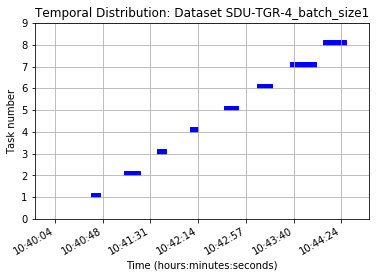

('Batch name: ', 'SDU-TGR-4_batch_size2')
('Dataset_file', 'SDU-TGR-4.yaml')
('Start time: ', 1540719607.333359)
('Batch name: ', 'SDU-TGR-4_batch_size2')
('n_tasks: ', 8)


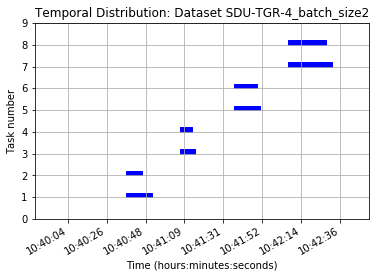

('Batch name: ', 'SDU-TGR-4_batch_size4')
('Dataset_file', 'SDU-TGR-4.yaml')
('Start time: ', 1540719607.333359)
('Batch name: ', 'SDU-TGR-4_batch_size4')
('n_tasks: ', 8)


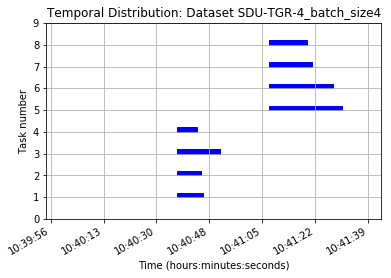

('Batch name: ', 'SDU-TGR-5_batch_size1')
('Dataset_file', 'SDU-TGR-5.yaml')
('Start time: ', 1540719607.372408)
('Batch name: ', 'SDU-TGR-5_batch_size1')
('n_tasks: ', 8)


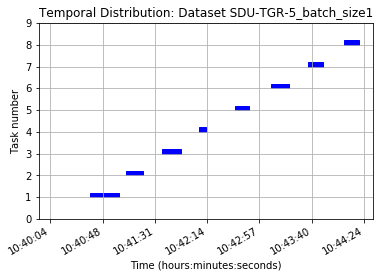

('Batch name: ', 'SDU-TGR-5_batch_size2')
('Dataset_file', 'SDU-TGR-5.yaml')
('Start time: ', 1540719607.372408)
('Batch name: ', 'SDU-TGR-5_batch_size2')
('n_tasks: ', 8)


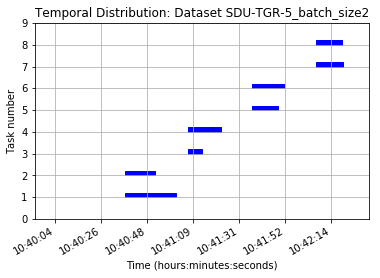

('Batch name: ', 'SDU-TGR-5_batch_size4')
('Dataset_file', 'SDU-TGR-5.yaml')
('Start time: ', 1540719607.372408)
('Batch name: ', 'SDU-TGR-5_batch_size4')
('n_tasks: ', 8)


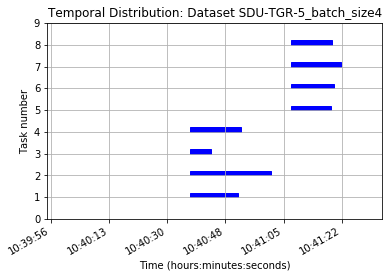

Points-SDC-TER-CR-1.yaml
('Cluster id:', 'cluster_0')
('Centroid:', [18.815634435824045, 10.533513796176232])
('Tasks:\n', ['e837466a-178f-409a-8d92-fa82254a8aba', '18736e7f-d0d0-49c7-a2b0-c6a18a90c87a'])

('Cluster id:', 'cluster_1')
('Centroid:', [15.754070602195721, 10.194390778919484])
('Tasks:\n', ['88dade60-1a98-4075-8709-5deb8dbe9c33', '8a2733e6-ba64-4da9-962a-ff31a2f44da5'])

Points-SDC-TER-CR-2.yaml
('Cluster id:', 'cluster_0')
('Centroid:', [6.068990869247822, 5.1254520018711425])
('Tasks:\n', ['ee4be259-15d8-4634-bcf1-e5e27290a516', 'ee9dc971-d5db-466b-8882-f68777ac816c'])

('Cluster id:', 'cluster_1')
('Centroid:', [5.568858756515713, 13.299921146573558])
('Tasks:\n', ['817f2f89-9a05-4ccd-a37c-05aed0a7a7b9', 'aa8c6b61-f37f-482f-8369-b47eb17b3685'])

Points-SDC-TER-CR-3.yaml
('Cluster id:', 'cluster_0')
('Centroid:', [13.863061805299111, 16.71259482552523])
('Tasks:\n', ['7e93e960-7d07-4a5d-bab2-7bdaf942639e', 'f6c71d92-8dd9-4c46-926d-ae26de791024'])

('Cluster id:', 'cluste

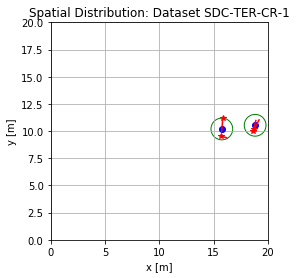

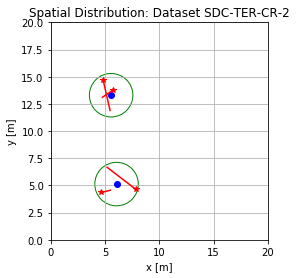

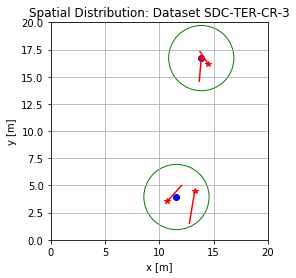

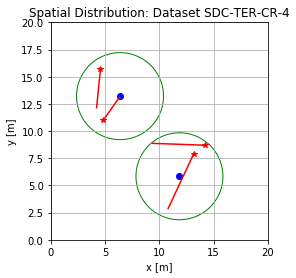

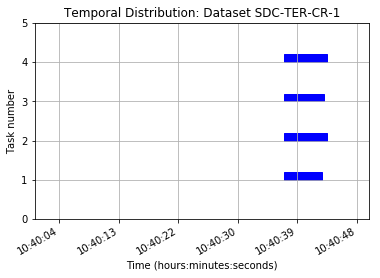

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 7, 520647))
('n_tasks: ', 4)
SDC-TER-CR-2


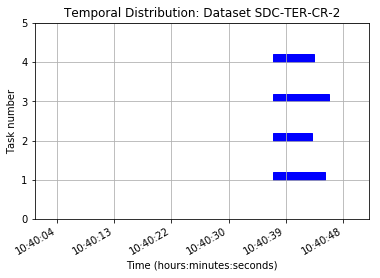

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 7, 638722))
('n_tasks: ', 4)
SDC-TER-CR-3


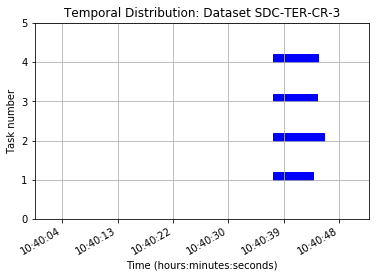

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 7, 772728))
('n_tasks: ', 4)
SDC-TER-CR-4


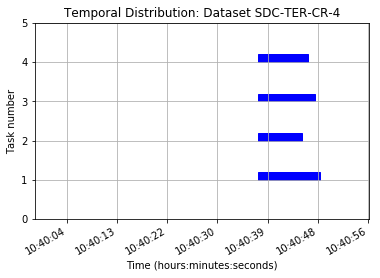

Points-SDC-TGR-CR-1.yaml
('Cluster id:', 'cluster_0')
('Centroid:', [13.264930140216308, 15.638672536567848])
('Tasks:\n', ['b0fdadb4-f7d7-4986-baa9-bb700c2f2dee', '4d03f1f9-2023-44fb-9487-3f5f6511ef14', '131ef9a2-0697-458a-873b-da681c1acb5e', '89688700-447f-4f55-a2b9-737bdd6558e8'])

('Cluster id:', 'cluster_1')
('Centroid:', [9.597355341564375, 10.123339040972004])
('Tasks:\n', ['c1b8b745-c993-45b8-ae5f-2915c51df64b', '047ce956-29bd-46c8-adb0-45790a8fe435', 'ee66b686-d2c5-44fd-85bf-2824fe357397', 'a7dd6bc8-0913-4a66-96b9-cf09d73b0031'])

Points-SDC-TGR-CR-2.yaml
('Cluster id:', 'cluster_0')
('Centroid:', [4.43052626641507, 14.556239119078061])
('Tasks:\n', ['3e57f580-b698-4f94-bb31-85730cf82f41', 'eea0b48c-2829-40ef-bbe4-5ada811e2288', '13591d46-632f-4fdf-b39d-5fe23bd13c86', '7d273bc8-48b1-4a01-84a3-ec4565cbd98e'])

('Cluster id:', 'cluster_1')
('Centroid:', [17.03398820476103, 15.983140337616735])
('Tasks:\n', ['d380aaf8-19c3-4f92-a83e-bf722459aa26', '01850a68-e8cc-4e15-90e5-aff83d5

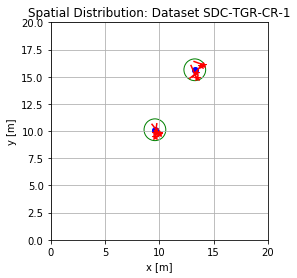

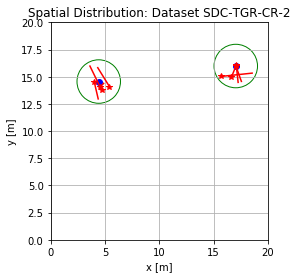

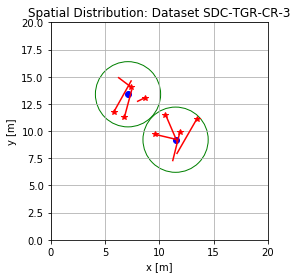

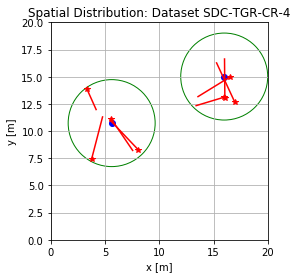

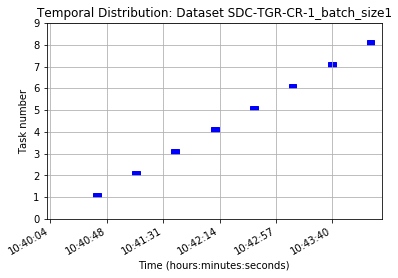

('Batch name: ', 'SDC-TGR-CR-1_batch_size2')
('Dataset_file', 'SDC-TGR-CR-1.yaml')
('Start time: ', 1540719607.463305)
('Batch name: ', 'SDC-TGR-CR-1_batch_size2')
('n_tasks: ', 8)


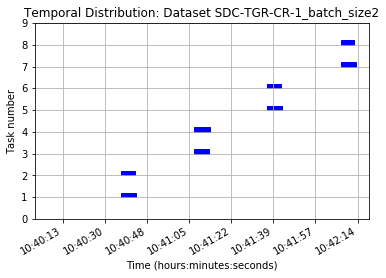

('Batch name: ', 'SDC-TGR-CR-1_batch_size4')
('Dataset_file', 'SDC-TGR-CR-1.yaml')
('Start time: ', 1540719607.463305)
('Batch name: ', 'SDC-TGR-CR-1_batch_size4')
('n_tasks: ', 8)


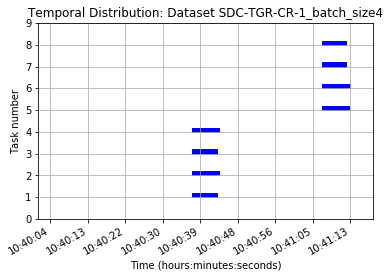

('Batch name: ', 'SDC-TGR-CR-2_batch_size1')
('Dataset_file', 'SDC-TGR-CR-2.yaml')
('Start time: ', 1540719607.576563)
('Batch name: ', 'SDC-TGR-CR-2_batch_size1')
('n_tasks: ', 8)


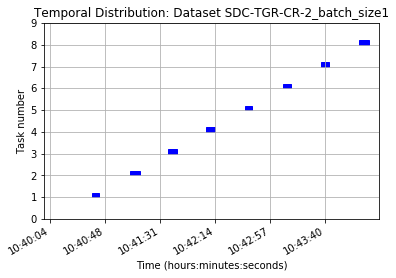

('Batch name: ', 'SDC-TGR-CR-2_batch_size2')
('Dataset_file', 'SDC-TGR-CR-2.yaml')
('Start time: ', 1540719607.576563)
('Batch name: ', 'SDC-TGR-CR-2_batch_size2')
('n_tasks: ', 8)


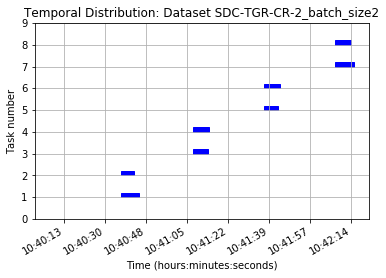

('Batch name: ', 'SDC-TGR-CR-2_batch_size4')
('Dataset_file', 'SDC-TGR-CR-2.yaml')
('Start time: ', 1540719607.576563)
('Batch name: ', 'SDC-TGR-CR-2_batch_size4')
('n_tasks: ', 8)


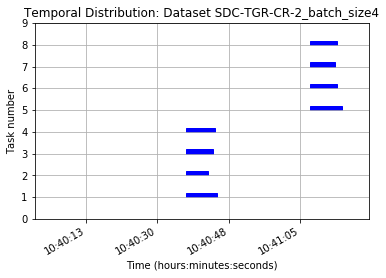

('Batch name: ', 'SDC-TGR-CR-3_batch_size1')
('Dataset_file', 'SDC-TGR-CR-3.yaml')
('Start time: ', 1540719607.702389)
('Batch name: ', 'SDC-TGR-CR-3_batch_size1')
('n_tasks: ', 8)


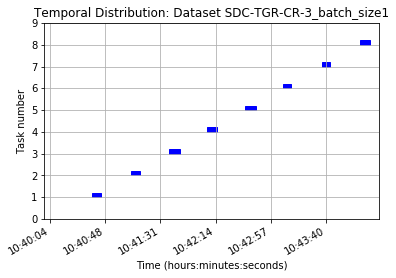

('Batch name: ', 'SDC-TGR-CR-3_batch_size2')
('Dataset_file', 'SDC-TGR-CR-3.yaml')
('Start time: ', 1540719607.702389)
('Batch name: ', 'SDC-TGR-CR-3_batch_size2')
('n_tasks: ', 8)


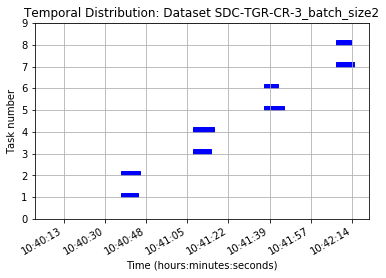

('Batch name: ', 'SDC-TGR-CR-3_batch_size4')
('Dataset_file', 'SDC-TGR-CR-3.yaml')
('Start time: ', 1540719607.702389)
('Batch name: ', 'SDC-TGR-CR-3_batch_size4')
('n_tasks: ', 8)


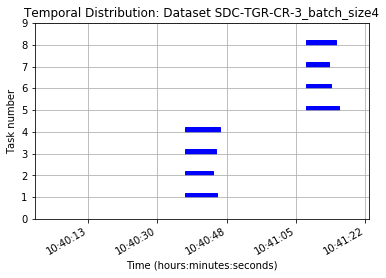

('Batch name: ', 'SDC-TGR-CR-4_batch_size1')
('Dataset_file', 'SDC-TGR-CR-4.yaml')
('Start time: ', 1540719607.851463)
('Batch name: ', 'SDC-TGR-CR-4_batch_size1')
('n_tasks: ', 8)


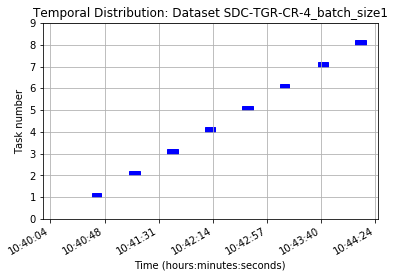

('Batch name: ', 'SDC-TGR-CR-4_batch_size2')
('Dataset_file', 'SDC-TGR-CR-4.yaml')
('Start time: ', 1540719607.851463)
('Batch name: ', 'SDC-TGR-CR-4_batch_size2')
('n_tasks: ', 8)


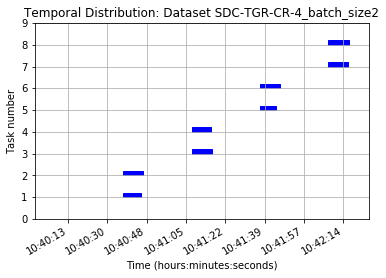

('Batch name: ', 'SDC-TGR-CR-4_batch_size4')
('Dataset_file', 'SDC-TGR-CR-4.yaml')
('Start time: ', 1540719607.851463)
('Batch name: ', 'SDC-TGR-CR-4_batch_size4')
('n_tasks: ', 8)


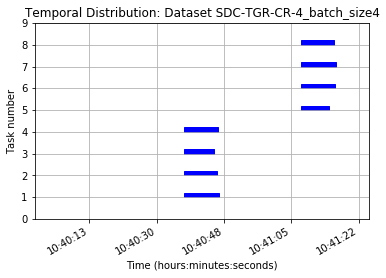

Points-TDU-TGR-1.yaml
('Pickup_points', [[14.03, 9.55], [15.51, 7.93], [12.35, 6.85], [9.7, 5.6], [9.16, 14.62], [8.19, 5.31], [7.15, 10.55], [13.46, 5.41]])
('Delivery_points', [[15.09, 5.69], [11.75, 6.57], [11.4, 2.96], [5.82, 6.57], [11.77, 11.59], [5.59, 2.27], [6.67, 14.52], [16.95, 7.36]])
Points-TDU-TGR-2.yaml
('Pickup_points', [[5.92, 8.95], [9.96, 9.91], [4.32, 14.57], [11.59, 4.42], [9.21, 15.74], [13.24, 6.77], [8.44, 6.28], [9.33, 11.56]])
('Delivery_points', [[5.5, 12.93], [13.55, 8.15], [3.13, 10.75], [10.11, 0.7], [11.54, 12.49], [13.42, 2.77], [8.77, 2.29], [8.78, 7.6]])
Points-TDU-TGR-3.yaml
('Pickup_points', [[7.23, 7.01], [13.83, 12.92], [5.2, 11.63], [5.34, 7.0], [14.62, 5.9], [8.88, 9.96], [8.62, 14.35], [10.08, 9.01]])
('Delivery_points', [[4.54, 9.97], [13.72, 16.92], [5.2, 7.63], [8.58, 9.35], [14.14, 9.87], [11.73, 7.15], [10.31, 17.98], [13.1, 11.63]])
Points-TDU-TGR-4.yaml
('Pickup_points', [[7.43, 12.7], [15.03, 13.61], [6.1, 14.22], [5.38, 6.64], [5.15, 5.

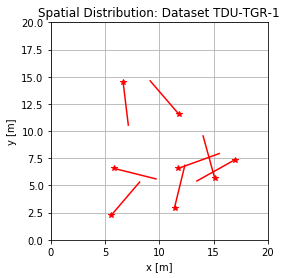

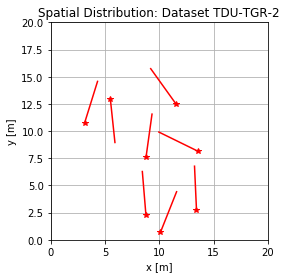

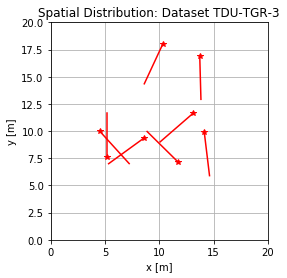

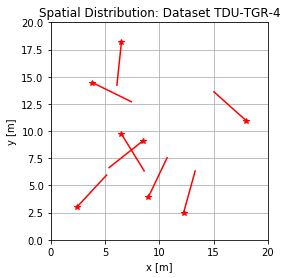

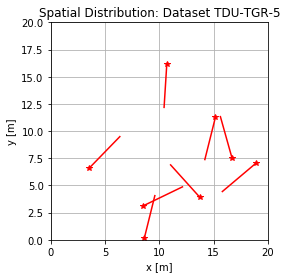

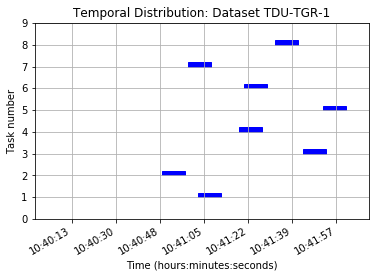

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 8, 6061))
('n_tasks: ', 8)
TDU-TGR-2


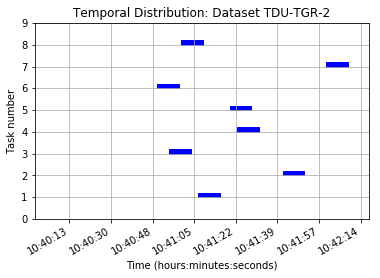

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 8, 83431))
('n_tasks: ', 8)
TDU-TGR-3


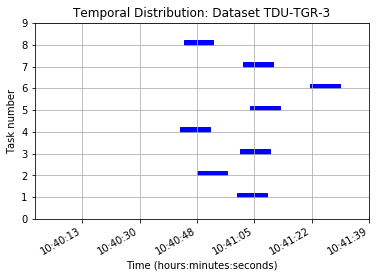

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 8, 164789))
('n_tasks: ', 8)
TDU-TGR-4


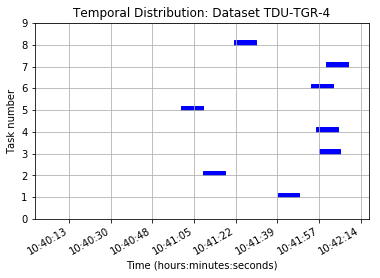

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 8, 249940))
('n_tasks: ', 8)
TDU-TGR-5


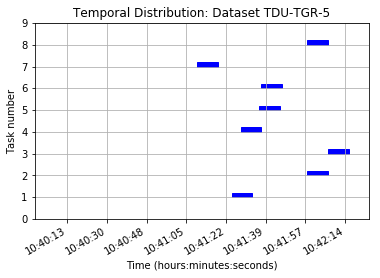

Points-TDC-TGR-ITW-1.yaml
('Pickup: ', [[10.53, 15.27], [12.19, 13.8], [9.37, 17.46], [10.29, 14.4], [4.76, 7.86], [7.13, 3.19], [7.22, 3.79], [6.95, 6.99]])
('Delivery: ', [[12.68, 18.64], [10.21, 17.27], [12.01, 14.45], [10.22, 18.4], [8.75, 8.21], [7.98, 7.09], [6.91, 7.78], [3.31, 5.32]])
Points-TDC-TGR-ITW-2.yaml
('Pickup: ', [[18.64, 11.22], [15.31, 9.83], [15.02, 10.16], [15.64, 11.81], [6.49, 4.24], [5.28, 5.26], [5.52, 5.89], [5.52, 8.48]])
('Delivery: ', [[15.3, 9.02], [12.25, 12.4], [13.54, 6.45], [15.67, 7.81], [3.54, 1.52], [6.15, 1.35], [7.51, 2.43], [2.01, 6.55]])
Points-TDC-TGR-ITW-3.yaml
('Pickup: ', [[9.73, 12.97], [9.37, 17.34], [9.2, 16.98], [8.35, 14.53], [14.49, 9.79], [14.95, 5.79], [16.92, 7.63], [16.46, 10.66]])
('Delivery: ', [[10.78, 16.83], [7.2, 13.98], [11.97, 14.09], [9.45, 18.38], [16.23, 6.19], [11.65, 8.06], [16.04, 11.53], [13.7, 7.78]])
Points-TDC-TGR-ITW-4.yaml
('Pickup: ', [[6.56, 8.71], [5.24, 11.99], [5.75, 4.86], [5.19, 10.79], [15.36, 4.73], [1

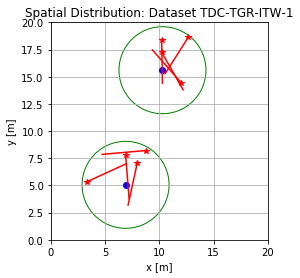

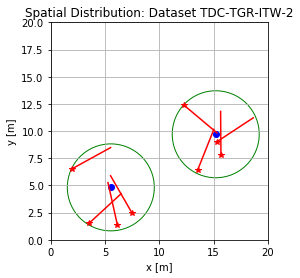

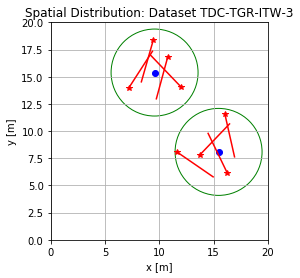

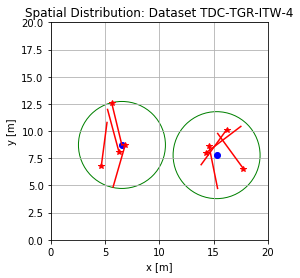

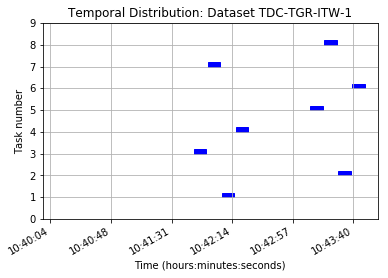

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 8, 447816))
('n_tasks: ', 8)
TDC-TGR-ITW-2


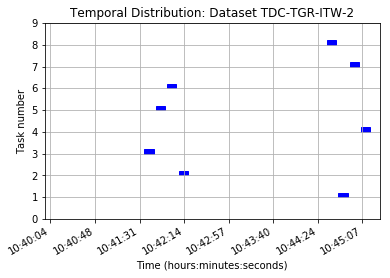

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 8, 555715))
('n_tasks: ', 8)
TDC-TGR-ITW-3


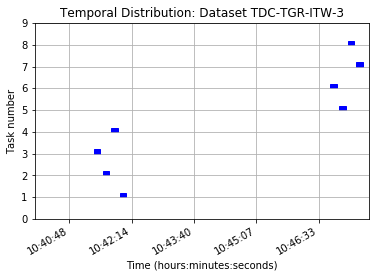

('Start time: ', datetime.datetime(2018, 10, 28, 10, 40, 8, 667190))
('n_tasks: ', 8)
TDC-TGR-ITW-4


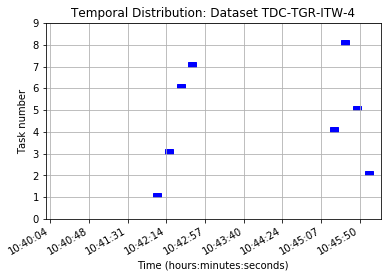

In [3]:
if __name__ == '__main__':
    
    map_dimensions, ropod_positions = load_data()
    xmin = map_dimensions['map']['x_min']
    xmax = map_dimensions['map']['x_max']
    ymin = map_dimensions['map']['y_min']
    ymax = map_dimensions['map']['y_max']
    xlim = (xmin, xmax)
    ylim = (ymin, ymax)
    print(xlim)
    print(ylim)

    plot_ropod_positions(ropod_positions, xlim, ylim)
    
    plot_dataset_uniform_spatial('../SDU-TER/Points', xlim, ylim)
    plot_dataset_temporal('../SDU-TER/', xlim, ylim)
    
    plot_dataset_uniform_spatial('../SDU-TGR/Points', xlim, ylim)
    plot_batch_temporal('../SDU-TGR', xlim, ylim)
    
    
    plot_dataset_clustered_spatial('../SDC-TER/Points', xlim, ylim)
    plot_dataset_temporal('../SDC-TER/', xlim, ylim)
    
    plot_dataset_clustered_spatial('../SDC-TGR/Points', xlim, ylim)
    plot_batch_temporal('../SDC-TGR', xlim, ylim)
    
    
    plot_dataset_uniform_spatial('../TDU-TGR/Points', xlim, ylim)
    plot_dataset_temporal('../TDU-TGR', xlim, ylim)
    
    plot_dataset_uniform_spatial_clustered_temporal('../TDC-TGR/Points', xlim, ylim)
    plot_dataset_temporal('../TDC-TGR', xlim, ylim)

Points-TDU-ST-10.yaml
('Pickup_points', [[13.0, 14.31], [5.8, 7.34], [7.98, 6.38], [9.62, 12.24], [4.68, 12.64], [10.38, 8.57], [11.16, 5.57], [13.5, 6.72], [12.97, 5.01], [10.4, 9.72]])
('Delivery_points', [[11.0, 10.85], [6.74, 3.45], [11.15, 3.94], [9.15, 16.21], [4.48, 16.63], [8.13, 11.88], [14.03, 2.78], [10.92, 9.78], [16.29, 7.24], [9.92, 13.69]])
Points-TDU-ST-100.yaml
('Pickup_points', [[9.2, 7.4], [9.78, 4.16], [5.04, 12.01], [13.62, 13.4], [5.34, 14.57], [15.12, 4.94], [12.68, 9.58], [4.89, 6.46], [9.5, 9.25], [5.34, 5.4], [5.31, 15.92], [13.36, 15.82], [14.61, 9.71], [9.17, 13.34], [15.52, 7.4], [4.4, 12.72], [12.72, 8.5], [12.37, 15.6], [11.35, 8.7], [8.82, 12.2], [6.34, 6.89], [5.6, 7.08], [11.42, 7.63], [9.34, 11.16], [11.31, 12.37], [11.76, 8.0], [5.07, 14.92], [8.68, 9.9], [6.27, 6.47], [11.18, 5.05], [7.76, 15.38], [5.08, 9.93], [8.17, 4.73], [14.15, 10.47], [4.42, 12.65], [7.08, 4.97], [15.66, 6.48], [15.54, 4.49], [8.58, 13.52], [8.72, 9.96], [4.3, 8.39], [14.28, 1

Points-TDU-ST-70.yaml
('Pickup_points', [[12.96, 11.09], [11.0, 13.48], [6.37, 4.56], [13.87, 9.01], [5.77, 15.99], [6.62, 12.44], [8.95, 12.39], [7.08, 12.45], [6.45, 5.07], [14.97, 5.04], [12.34, 10.76], [13.82, 9.83], [14.45, 5.64], [6.94, 6.48], [4.48, 13.91], [10.6, 15.03], [14.82, 6.05], [8.49, 9.62], [6.89, 12.16], [6.19, 11.38], [13.62, 5.99], [13.17, 6.46], [7.73, 6.95], [7.0, 7.21], [6.11, 14.71], [11.71, 9.06], [10.05, 6.86], [9.99, 7.19], [15.05, 12.32], [4.07, 14.63], [11.34, 14.2], [6.87, 13.93], [13.79, 5.39], [9.54, 7.94], [13.77, 15.7], [10.17, 13.41], [10.19, 9.06], [5.27, 13.69], [5.91, 9.81], [9.62, 4.59], [14.18, 14.99], [13.36, 11.66], [11.08, 11.01], [8.43, 15.84], [11.87, 10.99], [9.36, 15.05], [8.21, 11.0], [4.7, 14.66], [12.37, 4.08], [8.82, 13.46], [4.66, 8.33], [8.0, 5.4], [13.73, 15.76], [15.94, 7.35], [13.66, 6.39], [10.07, 14.74], [14.36, 4.89], [14.16, 10.54], [15.03, 8.43], [13.77, 5.34], [14.15, 6.11], [11.26, 9.55], [6.81, 12.67], [4.13, 7.5], [10.23,

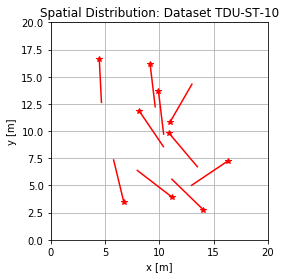

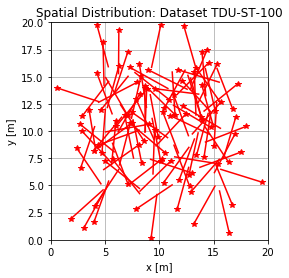

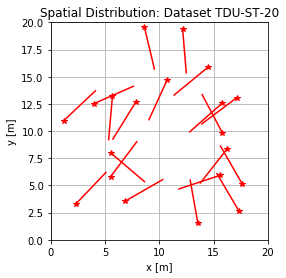

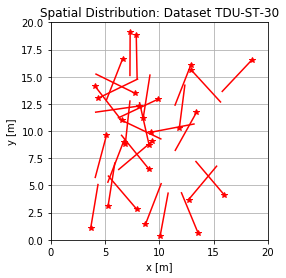

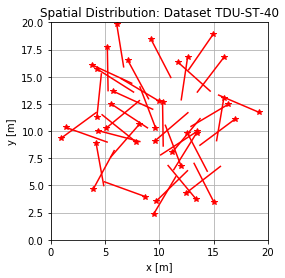

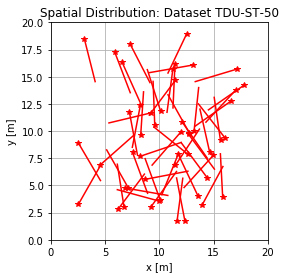

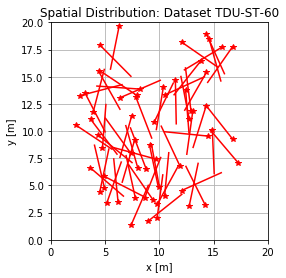

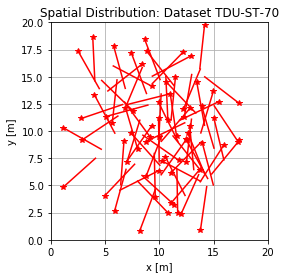

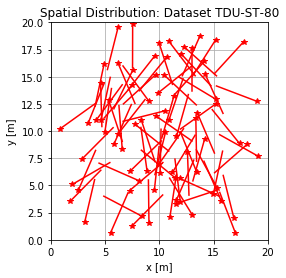

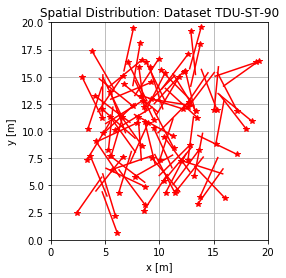

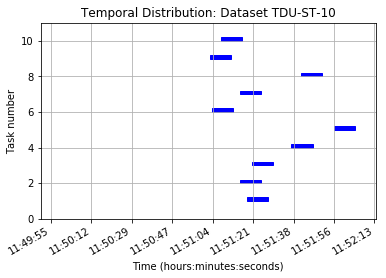

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 100)
TDU-ST-100


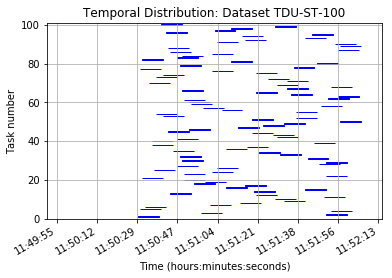

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 20)
TDU-ST-20


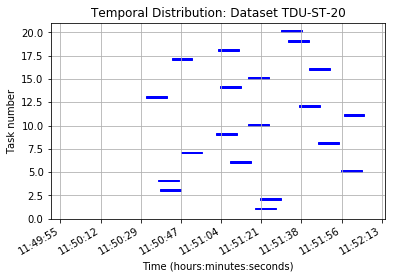

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 30)
TDU-ST-30


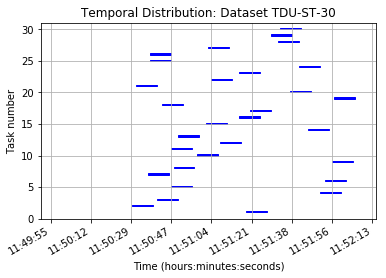

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 40)
TDU-ST-40


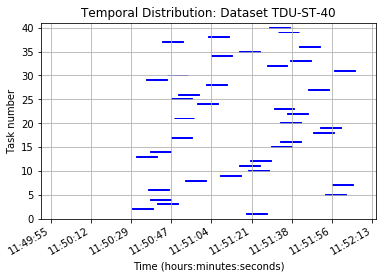

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 50)
TDU-ST-50


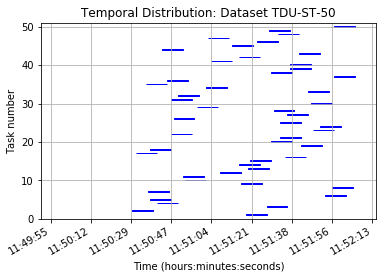

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 60)
TDU-ST-60


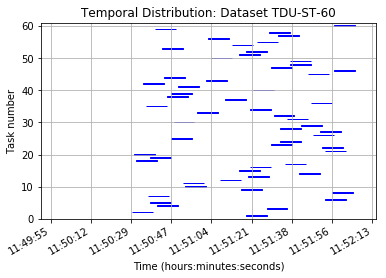

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 70)
TDU-ST-70


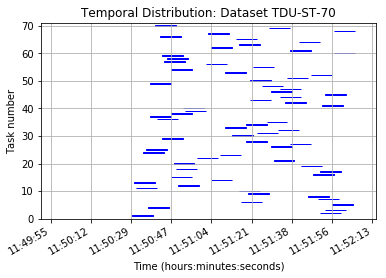

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 80)
TDU-ST-80


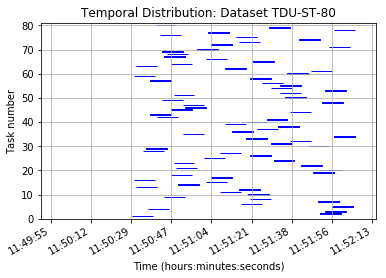

('Start time: ', datetime.datetime(2018, 11, 4, 11, 49, 59, 951656))
('n_tasks: ', 90)
TDU-ST-90


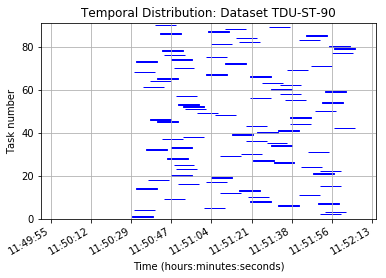

In [13]:
# Datasets for task scalability tests (TDU)
plot_dataset_uniform_spatial('../TDU-ST/Points', xlim, ylim)
plot_dataset_temporal('../TDU-ST', xlim, ylim)

Points-TDC-ST-10.yaml
('Pickup: ', [[5.93, 17.96], [8.83, 14.73], [7.98, 12.03], [8.07, 17.92], [7.75, 14.91], [6.35, 5.09], [7.27, 3.44], [8.39, 2.26], [4.97, 4.0], [6.62, 3.98]])
('Delivery: ', [[6.52, 14.01], [5.82, 12.1], [6.7, 15.82], [6.4, 14.28], [9.14, 18.67], [10.2, 6.18], [3.93, 5.64], [8.58, 6.26], [5.48, 7.97], [6.3, 7.97]])
Points-TDC-ST-100.yaml
('Pickup: ', [[9.69, 10.94], [9.39, 8.91], [9.06, 11.67], [10.09, 10.53], [9.76, 9.3], [10.51, 8.07], [10.09, 9.0], [9.86, 7.35], [9.02, 12.78], [8.61, 14.08], [7.05, 8.11], [9.74, 11.07], [11.7, 8.61], [9.28, 11.48], [7.9, 14.23], [8.75, 13.19], [6.39, 9.53], [10.26, 11.4], [11.53, 9.25], [9.01, 13.32], [10.67, 11.8], [9.99, 11.83], [8.39, 11.27], [8.34, 12.75], [9.02, 11.48], [9.64, 10.06], [9.54, 8.7], [9.27, 13.78], [9.86, 8.01], [12.92, 11.91], [10.61, 10.47], [9.6, 11.06], [9.45, 13.59], [9.88, 10.38], [8.63, 7.99], [9.37, 8.53], [10.42, 10.61], [9.12, 10.66], [11.02, 9.96], [8.8, 9.23], [11.4, 9.71], [9.74, 12.9], [9.61, 11

Points-TDC-ST-70.yaml
('Pickup: ', [[7.14, 11.06], [7.69, 11.46], [7.6, 9.04], [5.91, 13.86], [9.54, 11.45], [7.29, 10.4], [8.27, 9.12], [8.27, 11.36], [6.43, 10.76], [7.39, 10.74], [6.81, 11.42], [6.41, 10.64], [8.24, 12.49], [8.86, 12.74], [7.02, 10.51], [4.76, 13.27], [10.25, 9.96], [7.24, 10.72], [8.45, 13.11], [5.95, 8.63], [7.29, 11.09], [6.07, 9.14], [7.01, 9.77], [7.26, 10.57], [7.39, 11.11], [6.94, 12.11], [7.55, 11.49], [7.03, 11.68], [8.07, 9.59], [8.46, 13.01], [7.05, 9.92], [7.69, 11.52], [8.35, 8.65], [4.37, 10.57], [7.75, 10.44], [17.16, 3.49], [15.85, 5.89], [13.58, 7.4], [15.2, 4.46], [16.89, 2.83], [15.75, 5.73], [15.82, 5.61], [15.85, 5.07], [15.12, 3.84], [17.14, 8.53], [17.6, 2.33], [14.5, 7.75], [14.89, 3.31], [16.15, 5.06], [15.75, 5.33], [16.71, 5.03], [15.89, 4.96], [17.17, 7.61], [18.87, 3.87], [14.13, 2.81], [13.59, 6.87], [16.4, 8.84], [17.86, 5.01], [15.68, 6.03], [15.29, 4.97], [15.97, 7.39], [14.61, 2.96], [15.88, 5.67], [15.32, 1.96], [17.01, 4.78], [13.

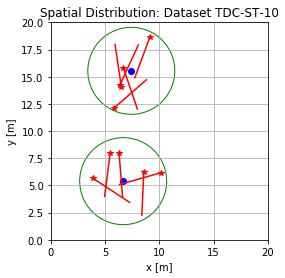

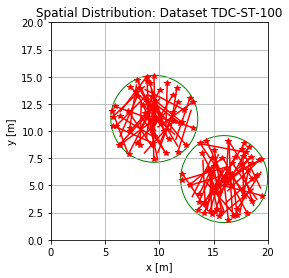

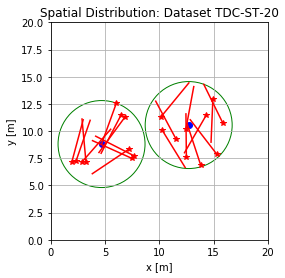

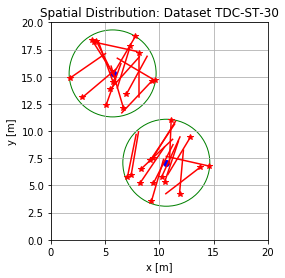

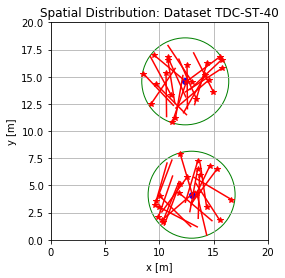

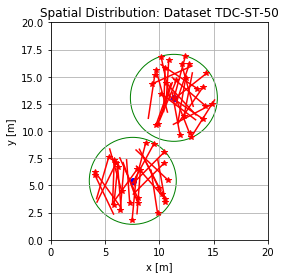

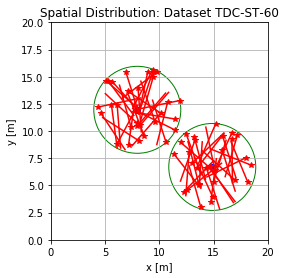

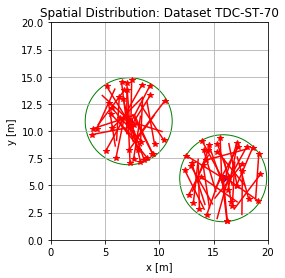

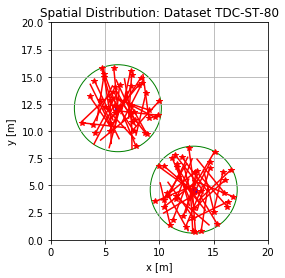

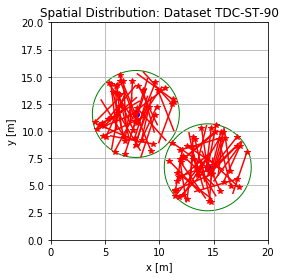

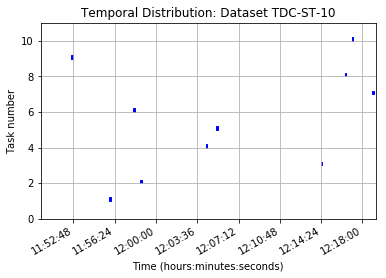

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 100)
TDC-ST-100


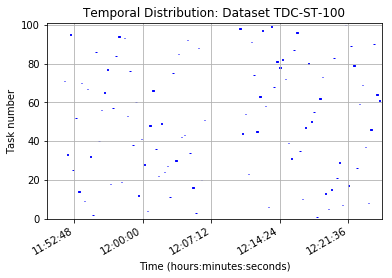

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 20)
TDC-ST-20


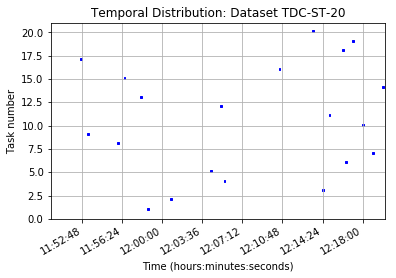

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 30)
TDC-ST-30


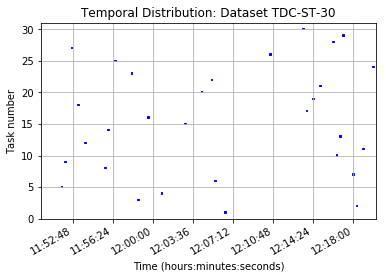

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 40)
TDC-ST-40


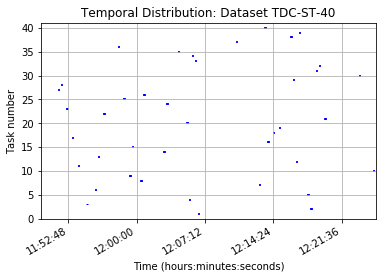

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 50)
TDC-ST-50


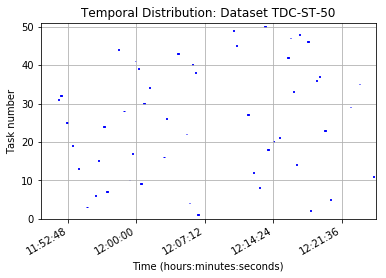

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 60)
TDC-ST-60


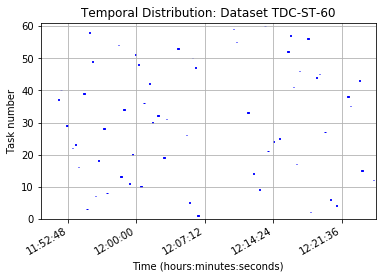

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 70)
TDC-ST-70


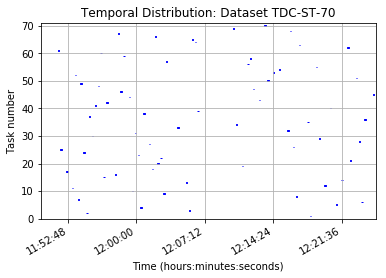

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 80)
TDC-ST-80


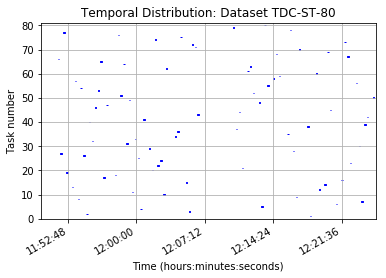

('Start time: ', datetime.datetime(2018, 11, 4, 11, 50, 6, 87380))
('n_tasks: ', 90)
TDC-ST-90


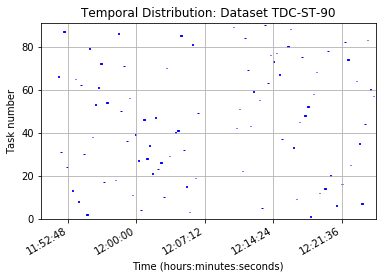

In [9]:
# Datasets for task scalability tests (TDC)
plot_dataset_uniform_spatial_clustered_temporal('../TDC-ST/Points', xlim, ylim)
plot_dataset_temporal('../TDC-ST', xlim, ylim)

(0.0, 100.0)
(0.0, 100.0)


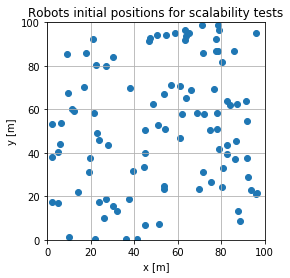

Points-TDU-SR-100.yaml
('Pickup_points', [[73.74, 49.05], [32.85, 50.65], [91.28, 46.22], [72.03, 53.46], [75.45, 21.77], [77.99, 40.14], [50.86, 94.77], [75.27, 38.28], [42.34, 25.61], [5.53, 81.95], [43.68, 64.82], [74.95, 20.26], [68.09, 61.44], [83.79, 92.05], [32.04, 13.26], [33.95, 34.29], [30.48, 26.89], [7.47, 77.45], [67.48, 54.21], [32.14, 35.88], [67.34, 17.12], [5.17, 67.07], [79.03, 5.4], [33.34, 51.59], [16.38, 37.88], [25.48, 27.25], [53.99, 41.91], [88.6, 90.66], [24.16, 72.21], [83.6, 53.17], [59.33, 57.59], [4.12, 12.99], [72.87, 61.08], [42.11, 22.49], [17.3, 52.05], [53.13, 95.08], [88.59, 50.09], [94.76, 27.35], [6.51, 93.19], [70.7, 44.09], [29.31, 69.2], [13.33, 88.4], [91.87, 43.86], [60.64, 20.66], [77.81, 75.67], [77.07, 54.73], [37.52, 41.37], [53.66, 73.73], [33.84, 8.89], [63.61, 57.08], [62.32, 55.74], [24.05, 38.55], [78.73, 87.65], [92.88, 80.06], [84.08, 90.98], [73.81, 18.78], [34.43, 16.5], [5.78, 25.42], [51.93, 16.35], [24.34, 55.59], [21.83, 87.31]

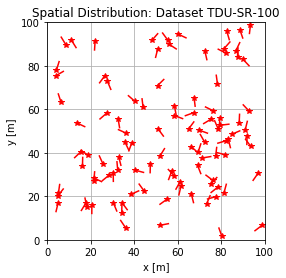

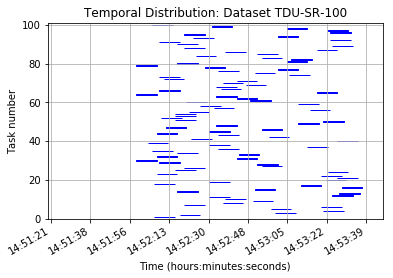

Points-TDC-SR-100.yaml
('Pickup: ', [[96.14, 87.37], [94.56, 86.03], [97.83, 84.07], [95.3, 88.37], [96.84, 83.08], [95.7, 82.48], [92.53, 87.23], [96.3, 83.73], [95.78, 87.39], [95.41, 86.52], [96.26, 85.02], [96.08, 86.41], [96.07, 86.54], [97.4, 83.45], [96.1, 87.01], [95.97, 84.18], [95.68, 86.66], [94.42, 83.45], [95.84, 85.45], [95.07, 83.43], [98.55, 87.97], [93.98, 88.36], [94.34, 83.63], [96.15, 85.61], [95.19, 86.56], [96.1, 85.64], [93.83, 85.68], [96.65, 86.2], [95.05, 86.54], [95.39, 86.12], [96.11, 86.0], [98.32, 85.71], [94.62, 87.63], [98.4, 82.82], [95.3, 84.61], [95.9, 86.26], [95.55, 86.48], [97.49, 81.91], [97.12, 86.32], [97.66, 87.95], [95.55, 85.24], [94.7, 84.63], [98.68, 83.07], [95.1, 87.76], [97.1, 84.06], [94.64, 82.39], [92.96, 86.38], [97.17, 83.47], [96.67, 87.66], [97.03, 86.53], [22.03, 29.04], [20.77, 29.86], [22.18, 32.3], [23.96, 32.2], [22.3, 32.26], [21.35, 27.35], [19.88, 26.07], [21.08, 29.23], [22.7, 28.27], [23.13, 28.11], [22.07, 28.86], [21.9

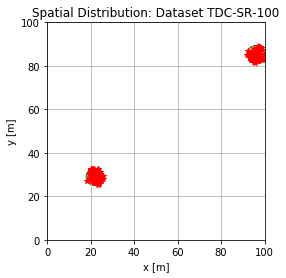

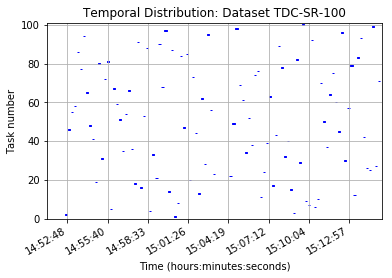

In [10]:
# Datasets for robot scalability tests
def load_data_scalability():
    map_file = "../../config_scalability/map.yaml"
    positions_file = "../../config_scalability/ropod_positions.yaml"
    map_dimensions = read_yaml_file(map_file)
    ropod_positions = read_yaml_file(positions_file)
    return map_dimensions, ropod_positions

map_dimensions, ropod_positions = load_data_scalability()
xmin = map_dimensions['map']['x_min']
xmax = map_dimensions['map']['x_max']
ymin = map_dimensions['map']['y_min']
ymax = map_dimensions['map']['y_max']
xlim = (xmin, xmax)
ylim = (ymin, ymax)
print(xlim)
print(ylim)

plot_ropod_positions(ropod_positions, xlim, ylim, True)
plot_dataset_uniform_spatial('../TDU-SR/Points', xlim, ylim)
plot_dataset_temporal('../TDU-SR', xlim, ylim)
plot_dataset_uniform_spatial_clustered_temporal('../TDC-SR/Points', xlim, ylim)
plot_dataset_temporal('../TDC-SR', xlim, ylim)
